### 1. Download libraries for NLP analysis

In [10]:
import google.datalab.bigquery as bq
import re
import string
import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

### 2. Download datasets from GOOGLE Big Query

In [2]:
#Get train and test data from Google Big query
qry_nlp_train = bq.Query('SELECT * FROM `nlp-test-useast1a.nlp.NLPTrainData`')
qry_nlp_test = bq.Query('SELECT * FROM `nlp-test-useast1a.nlp.NLPTestData`')
output_options = bq.QueryOutput.table(use_cache=False)
result_train = qry_nlp_train.execute(output_options=output_options).result()
result_test = qry_nlp_test.execute(output_options=output_options).result()
db_train = result_train.to_dataframe()
db_test = result_test.to_dataframe()

### 3. Get overview of the data

In [3]:
#make copy of training Data and test data
tweets = db_train.copy()
test_tweets = db_test.copy()
print('Tweets data shape: ', tweets.shape)
print('Test Data Shape',test_tweets.shape)

('Tweets data shape: ', (7613, 5))
('Test Data Shape', (3263, 4))


In [4]:
#Get full description of the training dataset
tweets.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [5]:
### Functions used throughout the code
def remove_punct(text):
    text_nopunct = ''.join([char for char in text if char not in string.punctuation])
    return text_nopunct
  
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

#### Feature Preparation and Sanity Checks


In [8]:
useful_cols = ['keyword', 'text', 'target']
text_cols = useful_cols[0:1]
tweets_feats = tweets[useful_cols]
for col in text_cols:
    tweets_feats[col] = tweets_feats[col].astype('str') 

tweets_feats.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
keyword    7613 non-null object
text       7613 non-null object
target     7613 non-null int64
dtypes: int64(1), object(2)
memory usage: 178.5+ KB


In [72]:
#Check that there is only one keyword per row in the  keyword column and conver to category
tweets['spaced_keywords'] = tweets['keyword'].str.split()
tweets['total_words_kws'] = tweets['keyword'].str.split().str.len()
tweets['total_words_kws'].unique()


array([1])

In [9]:
#Remove punctiation
tweets_feats['keywords_clean'] = tweets_feats['keyword'].apply(lambda x: remove_punct(x))
tweets_feats.head()

tweets_feats['keywords_tokenized'] = tweets_feats['keywords_clean'].apply(lambda x: tokenize(x.lower()))
tweets_feats.head()

,keyword,text,target,keywords_clean,keywords_tokenized
0,ablaze,We always try to bring the heavy. #metal #RT h...,0,ablaze,[ablaze]
1,ablaze,Crying out for more! Set me ablaze,0,ablaze,[ablaze]
2,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,ablaze,[ablaze]
3,ablaze,@PhDSquares #mufc they've built so much hype a...,0,ablaze,[ablaze]
4,ablaze,Ablaze for you Lord :D,0,ablaze,[ablaze]


In [45]:
# Counting Number oF Missing values
train.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,7613,NaN,NaN,NaN,5441.93,3137.12,1,2734,5408,8146,10873
keyword,7552,221,fatalities,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,5080,3341,USA,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,7613,7503,11-Year-Old Boy Charged With Manslaughter of T...,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,7613,NaN,NaN,NaN,0.42966,0.49506,0,0,0,1,1


In [46]:
# Features to keep
important_features = ['keyword', 'location', 'text', 'target']

In [ ]:
#tweets['spaced_keywords2'] = [re.split('\W+', keyword) for keyword in tweets['keyword']]


tweets['spaced_keywords2'] = tweets['keyword'].apply(lambda x: re.split('\W+', x))


In [47]:
#Missing values in test set
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [48]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

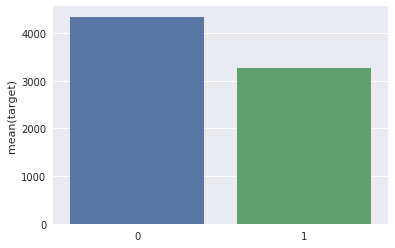

In [49]:
sns.barplot(train['target'].value_counts().index,train['target'].value_counts())
